# Game of 24

In [1]:
import re
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

def get_files_in_folder(folder_path):
    files = []
    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):
            files.append(folder_path + "/" +file)
    return files

def get_number(string):
    numbers = re.findall(r'\d+', string)
    numbers = list(map(int, numbers))
    return numbers[0] 
    
def get_params(file_path):
    data = {}

    file_name = file_path.split('/')[-1]
    params = file_name.split('_')

    data["set"] = params[0].split("-")[0]
    data["n_agents"] = get_number(params[1])
    data["n_steps"] = get_number(params[2])
    data["k"] = get_number(params[3])
    data["origin_value"] = get_number(params[4])
    data["backtrack"] = get_number(params[5].split(".")[1])/10
    data["resampling"] = params[6].split("-")[0]

    with open(file_path, 'r') as file:
        results = json.load(file)

    data["cost"] = results.pop("Cost")
    success = 0
    for experiment in results.values():
        if {"r":1} in experiment["Verifications"]:
            success +=1
    success_rate  = success/len(results)

    data["success_rate"] = success_rate

    return data

In [3]:
files = get_files_in_folder("logs/test/gameof24")

results = [get_params(file) for file in files]
results = sorted(results, key=lambda x: x["success_rate"], reverse=True)

df = pd.DataFrame(results)
df["total_cost"] = df["cost"].apply(lambda x: x["total_cost"])
df["name"] = df.apply(lambda x: f"{x['n_agents']}agents_{x['n_steps']}steps_{x['k']}k__{x['backtrack']}backtrack", axis=1)

In [4]:
tot_accuracy = 0.12
tot_cost = 1.9

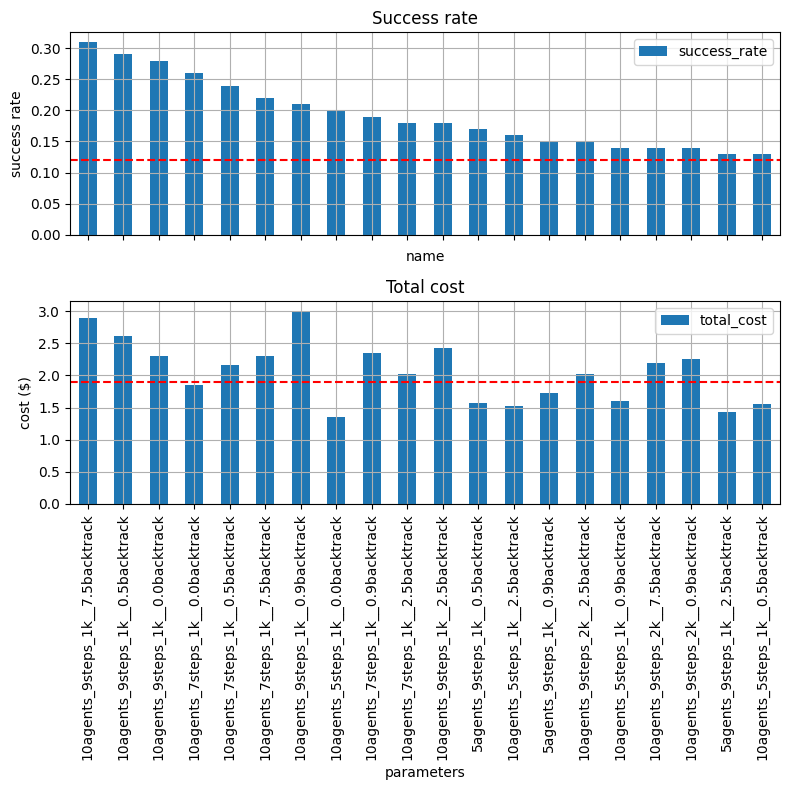

In [5]:
# prioritizing cost

import matplotlib.pyplot as plt

df_temp = df.copy()
df_temp.sort_values(by=["success_rate", "total_cost"], ascending=[False, True], inplace=True)
df_temp = df_temp.head(20)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot the first dataset on the first subplot
df_temp.plot(x="name", y="success_rate", kind="bar", title="Success Rate", ax=ax1)
ax1.axhline(y=0.12, color='r', linestyle='--')  # Adding a horizontal line
ax1.set_ylabel('success rate')
ax1.set_title('Success rate')
ax1.grid(True)
ax1.set_xticklabels([])  # Hide x-axis tick labels

# Plot the second dataset on the second subplot
df_temp.plot(x="name", y="total_cost", kind="bar", title="Cost", ax=ax2)
ax2.axhline(y=0.95*2, color='r', linestyle='--')  # Adding a horizontal line
ax2.set_xlabel('parameters')
ax2.set_ylabel('cost ($)')
ax2.set_title('Total cost')
ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


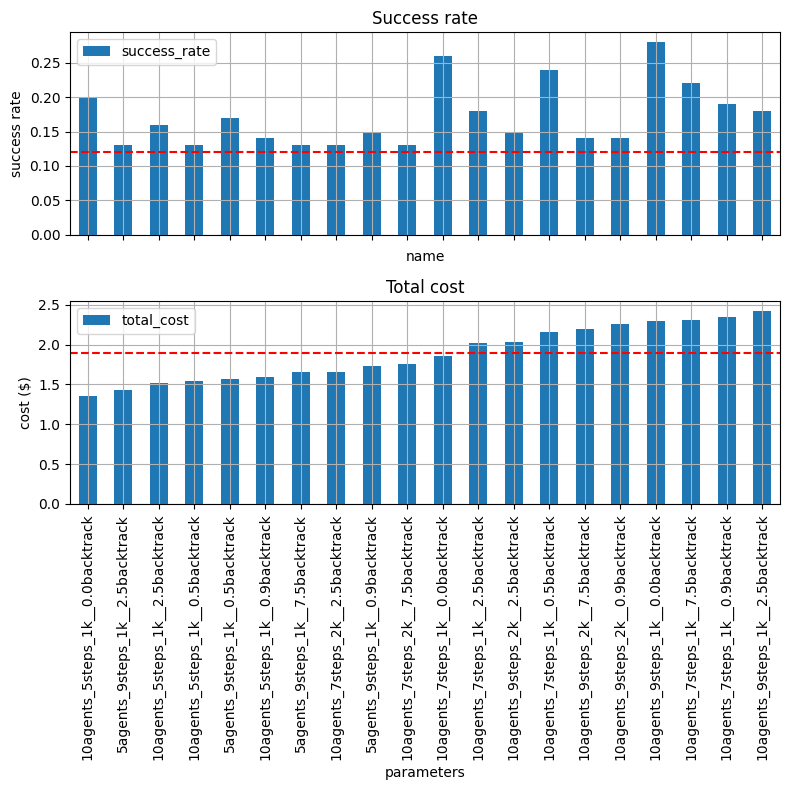

In [6]:
# prioritizing cost

import matplotlib.pyplot as plt

df_temp = df.copy()
df_temp = df_temp[df_temp.success_rate > 0.12]
df_temp.sort_values(by=["total_cost", "success_rate"], ascending=[True, False], inplace=True)
df_temp = df_temp.head(20)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot the first dataset on the first subplot
df_temp.plot(x="name", y="success_rate", kind="bar", title="Success Rate", ax=ax1)
ax1.axhline(y=0.12, color='r', linestyle='--')  # Adding a horizontal line
ax1.set_ylabel('success rate')
ax1.set_title('Success rate')
ax1.grid(True)
ax1.set_xticklabels([])  # Hide x-axis tick labels

# Plot the second dataset on the second subplot
df_temp.plot(x="name", y="total_cost", kind="bar", title="Cost", ax=ax2)
ax2.axhline(y=0.95*2, color='r', linestyle='--')  # Adding a horizontal line
ax2.set_xlabel('parameters')
ax2.set_ylabel('cost ($)')
ax2.set_title('Total cost')
ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
